Erivan INAN, Sarah OUAHAB, Sheïma MEBARKA

## Méthodes de simulation pour les modèles génératifs

Ce notebook a pour but l'implémentation (partielle et simplifiée) du papier ***``Diffusion guidée de Monte Carlo pour les problèmes inverses
linéaires bayésiens``*** (2023) par Gabriel Cardoso, Yazid Janati El Idrissi, Sylvain Le Corff et Eric Moulines.

DOI : 10.48550/arXiv.2308.07983
https://arxiv.org/abs/2308.07983


### <font color=darkred> Contexte du papier </font>

L’article traite des problèmes inverses linéaires mal posés dans un cadre bayésien.

Le but du papier est de résoudre des problèmes inverses linéaires bayésiens de la forme :

$$ y = Ax + \sigma_{y} \varepsilon $$

où :
- $y$ est l'observation bruitée
- $x$ est la variable à reconstruire
- $A$ une matrice de projection
- $\varepsilon \sim \mathcal{N}(0, I)$ la perturbation aléatoire agissant sur les pixels de $y$
- $\sigma_{y}$ le facteur de bruit ajouté à $y$

Dans ce cadre, l'objectif consiste à retrouver l'image $x$ à partir de l'observation bruitée $y$.

Une difficulté réside dans la **non-unicité** de $x$. En effet, plusieurs $x$ peuvent donner un même $y$. Egalement, on fait face à une **instabilité**, car les petites erreurs sur $y$ peuvent induire de grandes erreurs sur $x$.


#### Exemples d'application et types de données

**Applications :**

- Imagerie médicale : En IRM ou scanner, on n’observe pas directement l’image, mais des projections linéaires.
- Photographie computationnelle : On tente de restaurer une image floue ou basse - - Restauration d’images : Défloutage, inpainting (compléter une image partiellement masquée), super-résolution.

**Types de données :**

La plupart des applications se basent sur des images, mais on peut également exploiter ce problème pour les signaux, notamment audio.

#### Quelques définitions

**Problème inverse linéaire** :
On dit qu'un problème inverse est linéaire lorsque l'opérateur $A$ définit dans l'équation ci-dessus est linéaire.

**Problème inverse bayésien** : Le point de vue bayésien consiste à modéliser $x$ comme une variable aléatoire ayant une loi a priori et à utiliser les données $y$ pour obtenir une loi a posteriori de $x$, notée $p(x|y)$, à l'aide de la formule de Bayes :

$$ p(x|y) \propto p(y|x) \cdot p(x) $$

où :
- $p(x)$ est le prior (connaissance initiale sur $x$)
- $p(y|x)$ la vraisemblance (probabilité d'observer $y$ si $x$ est donné)
- $p(x|y)$ la loi a posteriori

L'avantage d'une telle formulation est qu'elle fournit non seulement une estimation de $x$, mais également une **incertitude** sur cette estimation.

**Problème bien posé** :
On dit qu'un problème inverse est bien posé au sens d'Hadamard, si et seulement si il satisfait les deux conditions suivantes :
- Quelle que soit la donnée initiale (ici $x$), le problème admet une unique solution $f(x)$.
- $f : \mathbb{R}^M \to \mathbb{R}^N$ est continue.

#### Retour à notre cadre

Dans le cas du problème d'inversion directe, celui-ci est bien posé si et seulement si $A$ est inversible, puisqu'alors $x \mapsto A^{-1}y$ est continue car on est en dimension finie.

Comme en pratique on ne sait pas si $A$ est carée, ni inversible, on ne peut pas procéder à une inversion directe. On cherche alors $x \in \mathbb{R}^N$ tel que $Ax$ et $y$ soient proches. Les moindres carrés consistent à résoudre : $\underset{x \in \mathbb{R}^N}{\arg\min} \, \left\| Ax - y \right\|_2^2$

Or, la solution à ce problème "explose" souvent, alors on ajoute une régularisation.

On s'intéresse donc à :

$$\underset{x \in \mathbb{R}^N}{\arg\min} \left( \left\| Ax - y \right\|_2^2 +  Reg(x) \right)$$

où $ x \mapsto Reg(x)$ est une est une fonction de régularisation qui pénalise les images non satisfaisantes (par exemple les images très irrégulières, images dont les valeurs explosent, etc).

Les limites des approches existantes dans la littérature avant ce papier incluent, mais ne se limitent pas à :
- Un choix de fonction de régularisation difficile, car elle doit refléter les propriétés de x, et qui pourtant, a une grande influence sur la reconstruction.
- Pas d’information sur l’incertitude de la solution.
- Ne fournit qu’une seule solution point-estimée.

### <font color=darkred> Description de la méthode </font>

<font color=darkblue> *Nous avons choisi de nous concentrer dans ce notebook sur le cas sans bruit. Dans la suite, nous allons décrire cette méthode et l'implémenter.* </font>

<u>Cas sans bruit</u> (sur l'observation), c'est-à-dire qu'on suppose l'observation comme exacte $\sigma_y =0$ :

On observe exactement les $dy$ premières coordonnées <u>x</u> de $X$ (avec $X = $ <u>x</u> + $\bar{x}$), ce qui simplifie le problème en inférant la loi postérieure sur $\bar{x}$, les $dx - dy$ états latents restants, sachant $y$.

Dans ce cas, on a une égalité stricte $y=Ax$ et seules les valeurs de $x$ la vérifiant sont compatibles avec l'observation. On peut donc voir la fonction de vraisemblance $p(y|x)$ comme une fonction de Dirac : $$p(y|x) = \mathbb{1}_{\{Ax = y\}}$$



Le papier fournit le pseudo-code de l'algorithme $\texttt{MCGdiff}$ suivant, que nous allons tenter d'implémenter dans la partie suivante :

![image-2.png](attachment:image-2.png)


On connait les $d_y$ premières coordonnées de $X$, on veut inférer la loi postérieure $\phi_0^y(\underline{x_0})$ sur les variables latentes de $X$ (variables restantes) sachant $y$.

L'échantillonnage a cette forme intégrale :

$$
\phi_0^y(\underline{x_0}) \propto \int g_1^y(x_1)^{-1} \, \overline{p}_0(y \mid \overline{x}_1) \, \underline{p}_0(\underline{x}_0 \mid x_1) \, \phi_1^y(dx_1)
$$

où :
- $\underline{x_0}$ est la partie inconnue de l'état $X$ et $y$ la partie observée.
- $\phi_0^y(\underline{x_0})$ est la densité cible au temps initial $t=0$
- $\underline{x_0}$ est le premier état de l'échantillon incomplet

Pour échantilloner, on utilise l'algo $\texttt{SMC}$ (Sequential Monte Carlo) permettant de mettre à jour de manière itérative les $N$ échantillons aléatoires (appelés particules) pour approximer la distribution à postériori $p(x|y)$.

Concrètement, on veut échantillonner la distribution $\phi_0^y(\underline{x_0})$ mais elle est trop compliquée pour qu'on puisse la tirer directement, alors on crée un chemin de distributions intermédiaires :

$$ \phi_n^y \rightarrow \phi_{n-1}^y \rightarrow ... \rightarrow \phi_0^y$$

où :

- $\phi_n^y$ est simple à échantillonner, par exemple gaussienne
- $ \phi_0^y$ la loi postérieure cible

L'algorithme $\texttt{MCGdiff}$ repose sur un échantillonnage séquentiel de Monte Carlo ($\texttt{SMC}$) dans le sens backward du temps, c’est-à-dire du temps final $t=n$ (où la distribution est simple) vers le temps initial $t=0$ (où l’on souhaite approximer la postérieure).

**1) On initialise les particules à l'instant final $s=n$**

Pour initialiser les particules à l’instant final $n$, on génère des échantillons à partir de la distribution $\phi_n^y$ à l’aide d’un mécanisme guidé par l’observation $y$. Cette étape combine l’information observée et du bruit aléatoire pour produire des particules réalistes, selon la formule suivante :

$$
\overline{\xi}_n^i = K_n \bar{\alpha}_n^{1/2} y + (1 - \bar{\alpha}_n) K_n \bar{z}_n^i,\quad
\xi_n^i = \overline{\xi}_n^i {}^{\mathbin{\frown}} \underline{z}_n^i
$$

où $\overline{z}_n^i \sim \mathcal{N}(0_{d_y}, I{d_y}) \hspace{5pt} \text{et} \hspace{5pt} \underline{z}_n^i \sim \mathcal{N}(0_{I_{d_x - d_y}}, I_{d_x - d_y})$.

L'ensemble de particules $\xi_n^i$ proches de la projection $K_n$ est initialisé.

**2) Propagation backward des particules de $s=n-1$ jusqu'à $s=0$**

la phase backward consiste à remonter progressivement de l’état final $x_n$ vers l’état initial $x_0$, en construisant à chaque étape une approximation de la distribution conditionnelle $p(x_s|y)$. Ce processus repose sur la méthode d’échantillonnage séquentielle $\texttt{SMC}$ : on commence par initialiser des particules à l'étape $s=n$, proches de l'observation $y$, puis on remonte pas à pas (de $s=n−1$ à $s=0$).

**Calcul des poids d’importance**

A chaque étape, on pondère les particules selon leur cohérence avec l'observation $y$ via des poids.

- Si $s=n-1$ (cas terminal), le poids est $ \widetilde{\omega}_{n-1}^i (\xi_n^i) = \mathcal{N}( \overline{\alpha}^{1/2}y ; \overline{\text{m}}_n(\xi_{s+1}^i), 2- \overline{\alpha}_n)$

- Sinon (cas intermédiaire), le calcul des poids se fait selon la formule :

$$ \frac{ \mathcal{N}( \overline{\alpha}^{1/2}y ; \overline{\text{m}}_{s+1}(\xi_{s+1}^i), \sigma_{s+1}^2 , 1- \overline{\alpha}_n) }{ \mathcal{N}( \overline{\alpha}_{s+1}^{1/2}y ; \overline{\xi}_{s+1}^i, 1 - \overline{\alpha}_{s+1}}) $$

Une fois les poids d'importance calculés pour toutes les particules à l’étape $s+1$, on effectue un rééchantillonnage.

**Rééchantillonnage multinomial**

Chaque particule $s$ va être va être engendrée à partir d’une particule "parente" $\xi_{s+1}^{I_{s+1}^i}$ au hasard parmi les $\xi_{s+1}^j$ avec une probabilité conditionnelle à leur poids. C'est un échantillonnage multinomial, où l'on tire $N$ fois dans une loi catégorielle discrète : $ \text{Cat}\left(\left\{ \tilde{\omega}_s\left(\xi_{s+1}^j\right) \middle/ \sum_{k=1}^N \tilde{\omega}_s\left(\xi_{s+1}^k\right) \right\}_{j=1}^N\right) $. Cela permet de concentrer les particules sur les zones de forte probabilité de la distribution cible.

Une fois l’ancêtre $\xi_{s+1}^{I_{s+1}^i}$ sélectionné, on génère un nouvel échantillon intermédiaire $\overline{\xi}_s^i$, qui combine l'observation $y$, un bruit $\overline{z}_s^i \sim \mathcal{N}(O_{d_s}, I_{d_s})$.

**Mise à jour des particules à l'instant $s$**

On met à jour les particules à l'instant $s$ via la formule :

$$ \bar{\xi}_s^i = K_s \bar{\alpha}_s^{1/2} y + (1 - K_s) \overline{m}_{s+1}(\xi_{s+1}^i) + (1 - \alpha_s)^{1/2} K_s^{1/2} \bar{z}_s^i,\quad
\underline{\xi}_s^i = \underline{m}_{s+1}(\xi_{s+1}^i) + \sigma_{s+1} \underline{z}_s^i
$$

**Particule complétée**

On concatène les deux parties pour obtenir la nouvelle particule à l'instant $s$ : $ \xi_n^i = \underline{\xi}_s^i {}^{\mathbin{\frown}} \overline{\xi}_s^i$.

Cette étape simule une particule $\xi_s^i$ à partir de la suivante $\xi_{s+1}^i$, en combinant :

- l'information observée $y$,
- la guidance par le score prior via $m_{s+1}$,
- le bruit aléatoire pour conserver la diversité.

Elle permet de remonter le processus de diffusion de façon informée par les données et le modèle.

<font color=darkblue> *Bien que nous n'ayons pas eu pour objectif l'implémentation du cas sans bruit, nous fournissons quand même cette explication du cas sans bruit, qui constitue l'une des différences principale avec le cas sans bruit.* </font>

<u>Cas avec bruit</u> (sur l'observation) avec une intensité de bruit $\sigma_y >0$, c'est-à-dire que l'observation est incertaine, c'est l'instance bruitée d’un processus aléatoire :

L'observation $y$ est bruitée, donc même si on connaît $x$, l'observation $y$ peut varier un peu à cause du bruit. $y$ suit une loi gaussienne centrée en $Ax$ donc la densité de vraisemblance est $p(y|x) = \mathcal{N}(y; Ax, \sigma_{y}^{2} I_{d_{y}})$. La vraisemblance $p(y|x)$ est donc élevée si $y$ est proche de $Ax$ et faible si $y$ est loin.

### <font color=darkred> Limites des approches existantes dans la littérature et Contributions de ce papier pour y répondre : </font> l'algorithme $\texttt{MCGdiff}$

<font color=darkblue> *Dans cette section, nous tâchons de lister les limites des approches existantes dans la littérature avant la publication de ce papier, puis pour chacune des limites, expliquer la contribution apportée dans ce papier pour pallier à la limite associée.*
</font>

- La littérature se concentrant sur l'optimisation de fonctions de régularisations ne permet certe de fournir une estimation, mais on ne sait pas combien on peut lui faire confiance.

$\to$ Le papier propose une approche bayésienne, dans laquelle on adopte un point de vue probabiliste : on médilise l'incertitude sur $x$ avec une loi a priori $p(x)$. La formulation bayésienne fournit non seulement une estimation de $x$, mais également une **incertitude** sur cette estimation. Elle permet également d'estimer l'ensemble des solutions probables et non pas juste une seule.

- Le problème est mal posé (non-unicité de la solution, instabilité car grands variations dans la reconstruction de $x$ dues à de petites perturbations sur $y$), d'où le besoin de priors puissants.

$\to$ Les auteurs proposent d'utiliser un modèle de diffusion comme prior pour échantilloner la loi posterior $p(x|y)$.

En particulier, les *score-based generative models* $\texttt{SGM}$. Ces modèles permettent de générer des échantillons réalistes à partir de bruit en inversant un processus de diffusion montrant une grande efficacité pour servir de priors dans les problèmes inverses bayésiens.

Cette approche par *score-based generative models* comprend bien des avantages : au delà de l'absence de nécéssité d'entraînement spécifique par tâche (défloutage, inpainting, super-resolution, etc), est son indépendance avec le problème inverse initial. C'est-à-dire que ce prior est appris au préalable, de manière non supervisée, sur les données de type $x$ du dataset.

De plus, ces modèles $\texttt{SGM}$ ne nécessitent pas de modéliser explicitement la densité $p(x)$. Ils apprennent directement son gradient logarithmique, qu'on appelle $\texttt{score}$ :

- Les précédentes approches dans la littérature $(\texttt{DDPM, score SDE})$ imposaient des hypothèses particulièrement fortes sur la coïncidence des lois jointes des processus avant $p$ et la loi de transition arrière $q$ :

$$ p_t(x_t) \hspace{2pt} q_{t+1}(x_{t+1}|x_t) = p_{t+1}(x_{t+1}) \hspace{2pt} p_t(x_t|x_{t+1}) \hspace{10pt} \forall t \in [0: n-1] $$

 Or, ce n'est pas le cas dans des contextes réalistes. En effet, la loi conditionnelle backward $p_t(x_t|x_{t+1})$ est en général inconnue. $q_t$ la loi de transition backward non plus.

$\to$ L'algorithme $\texttt{MCGdiff}$ permet de s'aquitter de cette hypothèse forte tout en fournissant une solution cohérente sans hypothèse restrictive.

De plus, dans les modèles basés sur la log-vraisemblance *likelihood-based models*, la méthode consistait en la modélisation directe de la densité de probabilité comme suit :

$$ p_\theta(x) = \frac{\mathrm{e}^{-f_\theta(x)}}{Z_\theta} $$

où :

- $f_\theta$ est une fonction à valeurs réelles paramétrée par un paramètre inconnu
- $\theta$, entraîné à partir du jeu de données
- $Z_\theta$ est une constante de normalisation

$Z_\theta$ est une "partition function" représentée par une intégrale sur tout l'espace des données, très grand dans le cadre d'un dataset d'images. Celle-ci permet de normaliser la fonction $\mathrm{e}^{-f_\theta(x)}$ pour en faire une densité de probabilité :

$$ Z_{\theta} = \int e^{-f_{\theta}(x)}\, dx \quad \text{et donc} \quad \int p_{\theta}(x)\, dx = 1 $$

Or, l'intégrale $Z_{\theta}$ n'a pas de solution fermée dans la majorité des cas, mais pour entraîner $p_{\theta}(x)$, il faudrait idéalement connaître $Z_\theta$.

$\to$ Les auteurs proposent l'algorithme d'échantillonnage $\texttt{SMC}$, permettant d'échantillonner des particules selon $p_\theta(x)$, sans la connaissance de $Z_\theta$.



Une approximation $q_t(x_t | x_{t+1})$ est choisie pour modéliser la transition entre deux instants du processus de diffusion dans le sens inverse du temps. Cette transition stochastique est construite à partir :

- du point $x_{t+1}$
- du score $s_t(x_{t+1}) = \nabla \text{log} \hspace{2pt} p_t(x_{t+1})$
- d'un bruit gaussien centré autour de $ x_{t+1} + \sigma_{t}^{2} \dot \nabla \text{log} p_t(x_{t+1})$ avec une variance isotrope $\sigma_{t}^{2} I$.

En effet, dans les *score-based approach*, on modélise directement la fonction de score suivante :

$$
s_\theta(x) = \nabla_x \log p_\theta(x)\,.
$$

C'est très pratique car cette quantité ne dépend pas de $Z_\theta$ comme $\nabla_x \log p_\theta(x) = - \nabla_x f_\theta(x)$.
Le score peut donc être paramétrisé sans se soucier de la constante de normalisation $Z_\theta$.

Une fois cette approximation $q_t(x_t | x_{t+1})$ définie, l’algorithme MCGdiff échantillonne une population de particules backward à l’aide de cette transition, et corrige l’erreur d’approximation par un mécanisme d’importance sampling.

Ainsi, à chaque étape $t$, on :

- Évalue la vraisemblance de chaque particule propagée selon l’observation $y$ et la structure du modèle backward,
- Calcule des poids d’importance non normalisés $\widetilde{\omega}_t^i$,
- Applique un rééchantillonnage multinomial selon ces poids pour sélectionner les ancêtres les plus cohérents avec la distribution cible.

Ce mécanisme permet à $\texttt{MCGdiff}$ :

de simuler des trajectoires backward cohérentes même si $p_t(x_t|x_{t+1})$ est inconnu, et d’approcher la postérieure $p(x|y)$ au lieu de simplement générer des échantillons réalistes.

- Les algorithmes existants dans la littérature ne garantissent pas formellement une cohérence pour l’échantillonnage conditionnel basé sur des modèles de diffusion.

$\to$ Sous des des hypothèses raisonnables, les auteurs démontrent que la distribution empirique des échantillons produits par MCGdiff converge vers la distribution a posteriori cible, lorsque le nombre de particules tend vers l’infini.

- De plus, les approches dans la littérature ne fournissent pas d'expériences numériques sur plusieurs cas où la loi posterior est connue.

$\to$ Les auteurs valident leurs résultats théoriques en générant des echantillons concentrés sur le support réel de la postérieure.

**$\to$ Ainsi, l'algortihme $\texttt{MCGdiff}$ proposé par les auteurs combine :**
- Le score-based prior, appris au préalable de manière non supervisée,
- Une méthode Monte Carlo séquentielle $\texttt{SMC}$ pour produire des échantillons de la posterior $p(x|y)$ de manière guidée grâce au score.

### <font color=darkred> Implémentation de l'algorithme </font> $\texttt{MCGdiff}$

<font color=darkblue> *Dans cette section, nous tentons d'explorer plusieurs implémentations de $\texttt{MCGdiff}$, avec ou sans $\texttt{SMC}$, avec ou sans structure d'autoencodeur.*

Tout au long de ce notebook, notre objectif sera de reconstruire des images MNIST bruitées en suivant au plus près le schéma de reverse diffusion décrit dans le papier.

</font>


<u>Cas sans bruit</u> (sur l'observation) : On propose d'implémenter l'approche dans laquelle on néglige le bruit de mesure c'est-à-dire lorsque $\sigma_{y}=0$. On tombe sur un problème d'inversion directe, on cherche $x$ tel que $y= Ax$.

L’objectif est d’échantillonner les coordonnées manquantes de $x \sim p_0$ conditionnellement à la partie observée $y$.

#### <font color=darkred> Implémentation du SMC seul</font>

Posons :

- $x \in \mathbb{R}^{d_x}$ = variable latente
- $y \in \mathbb{R}^{d_y}$ = observation
- $\bar{\alpha}_t = \prod_{s=1}^{t} (1 - \beta_s)$
- $\alpha_t = 1 - \beta_t$
- $K_t$ : matrice de gain (dans le papier c’est un scalaire, mais on garde la matrice générale)

On définit :
- $\vec{\xi_t^{i}}$ : particule guidée par l’observation
- $\xi_t^{i}$ : particule complète
- $m_t(x)$ : centre de transition du backward process


**Initialisation des particules à $t=n$**

On veut :

- tirer les $dy$ premières dimensions guidées par $y$
- et les $dx - dy$ restantes comme bruit libre.

La variable finale $\xi_n^{i} \in \mathbb{R}^{dx}$ est la concaténation de ces deux parties $\vec{\xi_n^{i}} \in \mathbb{R}^{dx}$ (guidée) et $\hat{z}_n^{i} \in \mathbb{R}^{dx-dy}$.

In [ ]:
import numpy as np
from scipy.stats import multivariate_normal
import pandas as pd
import matplotlib.pyplot as plt

# On commence par initialiser les particules
# xi_s et xi_bar_s

# Initialisation des particules
# Correspond à l'algorithme 1, lignes 1 à 4 :
# Pour chaque particule i :
# - on tire z_n^i ~ N(0_dy, I_dy)
# - on calcule \bar{ξ}_n^i = K_n sqrt(α_n) y + (1 - α_n) K_n z_n^i
# - on tire \hat{z}_n^i ~ N(0_dx-dy, I_dx-dy)
# - on pose ξ_n^i = \bar{ξ}_n^i + \hat{z}_n^i (concaténation)

def initialize_particles(N, dy, dx, alpha_n, K_n, y):
    """
    Initialise les particules ξ_n selon l'algorithme 1 MCGdiff (σ = 0).

    Args:
        N       : nombre de particules
        dy      : nombre de coordonnées observées (dim de y)
        dx      : dimension totale
        alpha_n : coefficient d'atténuation (alpha_n = 1 - β_n)
        K_n     : matrice de gain (matrice dx x dy)
        y       : observation de dimension dy

    Returns:
        xi_n (N x dx) : particules complètes à l'instant n
        xi_bar_n (N x dy) : partie observée conditionnée de chaque particule
    """
    sqrt_alpha_n = np.sqrt(alpha_n)
    d_remain = dx - dy # dimension de coord non observés

    # Matrices de particules
    xi_n = np.zeros((N, dx))       # Particules complètes
    xi_bar_n = np.zeros((N, dy))   # Parties observées conditionnées sur y

    for i in range(N):
        # Bruit sur la partie observée
        z_dy = np.random.randn(dy)

        # Calcul de ξ̄_n^i = K_n (√α_n y + (1 - α_n) z_dy)
        xi_bar = K_n @ (sqrt_alpha_n * y + (1 - alpha_n) * z_dy)
        xi_bar_n[i] = xi_bar

        # Bruit sur la partie non observée
        z_remain = np.random.randn(d_remain)

        # Construction finale ξ_n^i = concat(ξ̄_n^i, z_remain)
        xi_n[i, :dy] = xi_bar
        xi_n[i, dy:] = z_remain

    return xi_n, xi_bar_n

In [ ]:
# test de la fonction d'initialisation des particules
# initialize_particles(N, dy, dx, alpha_n, K_n, y)

# Paramètres
N = 5
dy = 3
dx = 6
alpha_n = 0.9
y = np.array([1.0, -0.5, 0.2])

# K_n : identité (plus simple)
K_n = np.eye(dy)

xi_n, xi_bar_n = initialize_particles(N, dy, dx, alpha_n, K_n, y)

df_init = pd.DataFrame({
    "ξ_n[i] (particule complète)": list(xi_n),
    "ξ̄_n[i] (partie observée)": list(xi_bar_n)
})

df_init

,ξ_n[i] (particule complète),ξ̄_n[i] (partie observée)
0,"[0.9014218690070872, -0.5870066395126547, 0.29...","[0.9014218690070872, -0.5870066395126547, 0.29..."
1,"[1.0153041294335923, -0.4758889611853043, 0.08...","[1.0153041294335923, -0.4758889611853043, 0.08..."
2,"[0.8882982584807886, -0.38320954424339304, 0.2...","[0.8882982584807886, -0.38320954424339304, 0.2..."
3,"[0.9773368133961026, -0.5702720069174846, 0.29...","[0.9773368133961026, -0.5702720069174846, 0.29..."
4,"[1.0411294677011507, -0.2762872350451256, 0.19...","[1.0411294677011507, -0.2762872350451256, 0.19..."


**Pondération des particules à $t=n−1$**

In [ ]:
def compute_terminal_weights(xi_n, alpha_bar_n, y, m_bar_fn, dy):
    """
    Calcule les poids terminaux ω̃_{n−1} selon l'équation (2.4) du papier MCGdiff.

    Args:
        xi_n       : (N x dx) particules à l'étape n
        alpha_bar_n: scalaire, alphā_n
        y          : observation (dy,)
        m_bar_fn   : fonction donnant m̄_n(x) ∈ ℝ^dy
        dy         : dimension observée

    Returns:
        weights : (N,) poids non normalisés ω̃_{n−1}
    """
    N = xi_n.shape[0]
    weights = np.zeros(N)
    cov = (2 - alpha_bar_n) * np.eye(dy)
    sqrt_alpha_bar_n = np.sqrt(alpha_bar_n)

    for i in range(N):
        m_bar = m_bar_fn(xi_n[i], dy)
        weights[i] = multivariate_normal.pdf(sqrt_alpha_bar_n * y, mean=m_bar, cov=cov)

    return weights


def compute_intermediate_weights(xi_s, xi_bar_sp1, alpha_bar_sp1, sigma2_sp1, y, K_sp1, m_fn, m_bar_fn, dy):
    """
    Calcule les poids intermédiaires ω̃_s selon l'équation (2.4) du papier MCGdiff.

    Args:
        xi_s         : (N x dx) particules à l'étape s
        xi_bar_sp1   : (N x dx) particules observées à l'étape s+1
        alpha_bar_sp1: scalaire, alphā_{s+1}
        sigma2_sp1   : scalaire, σ²_{s+1}
        y            : observation (dy,)
        K_sp1        : matrice (dx x dy)
        m_fn         : fonction donnant m_{s+1}(x) ∈ ℝ^dx
        m_bar_fn     : fonction donnant m̄_{s+1}(x) ∈ ℝ^dy
        dy           : dimension observée

    Returns:
        weights : (N,) poids non normalisés ω̃_s
    """
    N, dx = xi_s.shape
    weights = np.zeros(N)
    sqrt_alpha_bar_sp1 = np.sqrt(alpha_bar_sp1)

    cov1 = (sigma2_sp1 + 1 - alpha_bar_sp1) * np.eye(dy)
    cov2 = sigma2_sp1 * np.eye(dx)
    cov3 = (1 - alpha_bar_sp1) * np.eye(dx)

    mean_denom = K_sp1 @ (sqrt_alpha_bar_sp1 * y)

    for i in range(N):
        m_bar = m_bar_fn(xi_s[i], dy)
        m = m_fn(xi_s[i])
        term1 = multivariate_normal.pdf(sqrt_alpha_bar_sp1 * y, mean=m_bar, cov=cov1)
        term2 = multivariate_normal.pdf(xi_bar_sp1[i], mean=m, cov=cov2)
        term3 = multivariate_normal.pdf(xi_bar_sp1[i], mean=mean_denom, cov=cov3)
        weights[i] = term1 * term2 / term3

    return weights

In [ ]:
# Fonctions m(x) et m̄(x) de projection
def m_bar_fn(x, dy):  # projette sur les dy premières coords
    return x[:dy]

def m_fn(x):  # identité ici
    return x

In [ ]:
# test des fonctions de calcul des poids terminaux et intermédiaires
# compute_terminal_weights(xi_n_minus_1, alpha_n, y, m_bar_fn, dy)
# et compute_general_weights(xi_s, xi_bar_sp1, alpha_sp1, sigma_sp1, y, K_sp1, m_fn, m_bar_fn, dy)

# Paramètres
N = 4
dx = 5
dy = 2
alpha_bar_n = 0.9
sigma2_sp1 = 0.1
y = np.array([0.5, -1.2])
K_sp1 = np.eye(dx)[:, :dy]  # dx x dy

# Particules fictives
np.random.seed(42)
xi_n = np.random.randn(N, dx)
xi_s = np.random.randn(N, dx)
xi_bar_sp1 = np.random.randn(N, dx)

# Calcul des poids
terminal_weights = compute_terminal_weights(xi_n, alpha_bar_n, y, m_bar_fn, dy)
intermediate_weights = compute_intermediate_weights(xi_s, xi_bar_sp1, alpha_bar_n, sigma2_sp1, y, K_sp1, m_fn, m_bar_fn, dy)

# Affichage
df_poids = pd.DataFrame({
    "Poids terminaux ω̃_{n−1}": terminal_weights,
    "Poids intermédiaires ω̃_s": intermediate_weights
})

df_poids

,Poids terminaux ω̃_{n−1},Poids intermédiaires ω̃_s
0,0.091804,3.792707e+00
1,0.004012,1.273924e+03
2,0.078977,3.139204e-26
3,0.088142,2.069732e-28


**Propagation des particules**

In [ ]:
# Propagation des particules
# Implémente l'étape de l'algorithme 1, ligne 11 :
# ξ_s^i ← m_{s+1}(ξ_{s+1}^{I_{s+1}^i}) + σ_{s+1} z
# Transition de Markov backward, qui sert à simuler les ξ_s à partir des ξ_{s+1}
# Il s'agit d'une transition stochastique, on part d'un échantillon ξ_{s+1} et
# on lui ajoute du bruit gaussien via la fonction ci-dessous.

def propagate_particles(xi_sp1, alpha_bar_sp1, sigma2_sp1, y, K_sp1, score_fn):
    """
    Propagation backward des particules ξ_{s+1} vers ξ_s selon le modèle MCGdiff, cas sans bruit.

    Args:
        xi_sp1        : (N x dx) particules à l'étape s+1
        alpha_bar_sp1 : scalaire, ᾱ_{s+1}
        sigma2_sp1    : scalaire, σ²_{s+1}
        y             : observation (dy,)
        K_sp1         : matrice (dx x dy)
        score_fn      : fonction s_{s+1}(x) retournant le score (∇ log p(x)) ∈ ℝ^dx

    Returns:
        xi_s : (N x dx) particules propagées à l'étape s
    """
    N, dx = xi_sp1.shape
    dy = y.shape[0]
    xi_s = np.zeros((N, dx))
    sqrt_alpha_bar_sp1 = np.sqrt(alpha_bar_sp1)

    for i in range(N):
        x_sp1 = xi_sp1[i]

        # Moyenne guidée
        score = score_fn(x_sp1)                     # ∈ ℝ^dx
        mean = x_sp1 + sigma2_sp1 * score           # m_{s+1}(x_{s+1})

        # Tirage aléatoire dans le backward kernel avec guidage
        noise = np.random.randn(dx)
        x_s = mean + np.sqrt(sigma2_sp1) * noise    # propagation

        xi_s[i] = x_s

    return xi_s

In [ ]:
# Paramètres du test
N = 5
dx = 6
dy = 3
alpha_bar_n = 0.9
alpha_bar_sp1 = 0.85
sigma2_sp1 = 0.1
y = np.array([1.0, -0.5, 0.2])
K_n = np.eye(dy)               # pour initialisation
K_sp1 = np.eye(dx)[:, :dy]     # pour projection dans compute_intermediate_weights

# Fonctions m, m_bar et score
def m_bar_fn(x, dy): return x[:dy]
def m_fn(x): return x
def score_fn(x): return -x  # score d'une loi normale centrée

# Étape 1 : initialisation des particules à l'étape n
xi_n, xi_bar_n = initialize_particles(N, dy, dx, alpha_bar_n, K_n, y)

# Étape 2 : test des poids terminaux
terminal_weights = compute_terminal_weights(xi_n, alpha_bar_n, y, m_bar_fn, dy)

# Étape 3 : propagation des particules backward : xi_{s+1} -> xi_s
xi_sp1 = xi_n  # on part de l'étape n
xi_s = propagate_particles(xi_sp1, alpha_bar_sp1, sigma2_sp1, y, K_sp1, score_fn)

# Étape 4 : génération de xi_bar_{s+1} fictif
xi_bar_sp1 = xi_sp1  # on suppose que xi_sp1 est connu (comme dans SMC)

# Étape 5 : test des poids intermédiaires
intermediate_weights = compute_intermediate_weights(xi_s, xi_bar_sp1, alpha_bar_sp1, sigma2_sp1, y, K_sp1, m_fn, m_bar_fn, dy)

# Résumé final
import pandas as pd
df_final_test = pd.DataFrame({
    "Particules ξ_n (completes)": list(xi_n),
    "Poids terminaux ω̃_{n−1}": terminal_weights,
    "Particules propagées ξ_s": list(xi_s),
    "Poids intermédiaires ω̃_s": intermediate_weights
})

df_final_test

,Particules ξ_n (completes),Poids terminaux ω̃_{n−1},Particules propagées ξ_s,Poids intermédiaires ω̃_s
0,"[0.9007658742659848, -0.4929075466916386, 0.07...",0.054664,"[0.8413879034001064, -0.137304350602858, -0.15...",30290.106233
1,"[0.9414822858924804, -0.3739883592360545, 0.22...",0.054750,"[0.9409755109916504, -0.25403659778408505, 0.2...",5094.838178
2,"[0.9451006941395186, -0.3178772834438563, -0.0...",0.052754,"[0.7422147787827656, -0.5397919036715124, -0.1...",2.485689
3,"[0.957859375704064, -0.6730985404853461, 0.167...",0.054042,"[0.943518022828681, -0.6293305520686242, -0.45...",18.538153
4,"[0.867833937761195, -0.5245173533837105, 0.281...",0.054601,"[0.7202206658234974, -0.37670797563086655, 0.2...",1.816984


<font color=darkblue>  D'après les tests, l'implémentation du SMC semble conforme. Les poids sont bien calculés et ajustés, et les particules sont propagées. Ce code constitue l'implémentation la plus fidèle et rigoureuse par rapport au papier. </font>

Nous allons voir dans la prochaine implémentation, une version simplifiée de SMC, notamment au niveau du rééchantillonnage.

#### <font color=darkred> Tentative d’implémentation complète de l’algorithme original </font>

Nous avons dans un premier temps implémenté l’algorithme $\texttt{MCGdiff}$ tel que présenté dans l’article, en y intégrant le calcul des poids d’importance et l’échantillonnage à chaque étape du processus backward. Cette version fidèle applique la propagation des particules par Langevin, un rééchantillonnage selon les poids, ainsi qu’une pondération impliquant trois distributions normales.
Cependant, cette version s’est révélée très coûteuse en temps de calcul, notamment en raison :

- du calcul explicite de poids complexes pour chaque particule,
- de la dimension élevée (28×28 = 784),
- et du nombre d’étapes de reverse diffusion (100 steps).

Pour des raisons pratiques, cette version complète n’a pas pu être exploitée à grande échelle. Néanmoins, elle nous a permis de valider la compréhension des éléments clés de l’algorithme : le rôle du score, la structure backward, et l’intérêt du resampling par $\texttt{SMC}$.

#### <font color=darkred> 1) Version simplifiée de </font>  $\texttt{MCGdiff}$ <font color=darkred> sur les données MNIST </font>

Nous avons alors mis en place une version simplifiée fidèle du processus inverse décrit dans le papier, en combinant une diffusion inversée et un guidage par le score a posteriori. Comme dans le papier, chaque particule évolue dans le temps selon une dynamique inspirée des processus de diffusion inversés (reverse DDPM), et le guidage se fait à l’aide d’un score, c’est-à-dire le gradient du log de la densité cible.

Dans $\texttt{MCGdiff}$, ce score est en principe celui de la loi posterior $p(x|y)$, qui est difficile à connaître ou à calculer explicitement. Les auteurs contournent ce problème en proposant une estimation pratique et stable via des approximations ou des modèles appris. De notre côté, pour rester dans l’esprit de l’article tout en gardant une implémentation simple, on a approximé ce score de manière analytique.

On décompose le score $\nabla \log p(x \mid y)$ en deux termes :

$$\nabla \log p(x \mid y) = \nabla \log p(y|x) + \nabla \log p(x) $$

- un terme de **vraisemblance**, qui pousse les particules à se rapprocher de l’observation $y$,
- un terme de **prior**, qui les attire vers une région probable selon notre connaissance a priori.

Dans notre cas, l'observation $y$ est une image MNIST bruitée (avec un bruit gaussien $\sigma= 0.3$), et le prior est une loi normale centrée sur la moyenne empirique des chiffres MNIST. Cette simplification évite d'entraîner un score model complexe, tout en gardant un guidage raisonnable dans l'espace des images.

Ce choix d’approximation du score permet de respecter la logique du guidage dans $\texttt{MCGdiff}$, d'obtenir une reconstruction correcte sans apprentissage supervisé et d'exécuter la méthode rapidement grâce à une formulation entièrement vectorisée.

Enfin, même si on n’a pas intégré le resampling $\texttt{SMC}$ complet du papier (qu'on a quand même codé plus haut), on conserve les éléments essentiels du schéma backward guidé, ce qui fait de notre version une bonne illustration des idées centrales de $\texttt{MCGdiff}$.

99it [00:07, 12.44it/s]


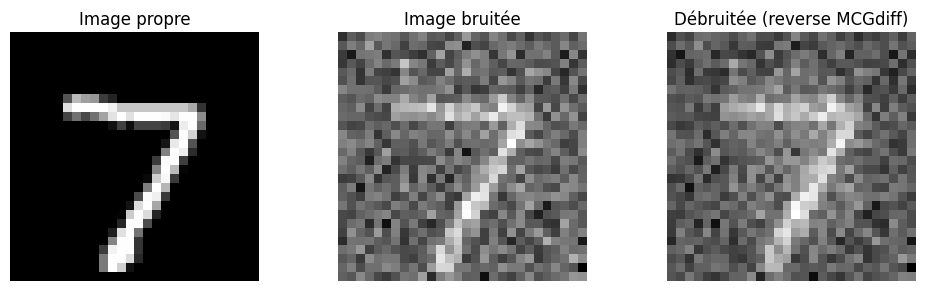

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Données MNIST
transform = transforms.ToTensor()
dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
x_clean, _ = dataset[0]
x_clean = x_clean.unsqueeze(0)  #(1,1,28,28)
dx = x_clean.numel()

# Ajout de bruit gaussien pour simuler l'observation y
sigma_noise = 0.3
x_noisy = x_clean + sigma_noise * torch.randn_like(x_clean)
y_vec = x_noisy.view(-1).numpy()

# Paramètres diffusion
num_steps = 100
betas = np.linspace(1e-4, 0.015, num_steps)
alphas = 1 - betas
cum_alphas = np.cumprod(alphas)

# Moyenne empirique pour prior
mnist_mean = torch.stack([dataset[i][0] for i in range(1000)]).mean(dim=0)
prior_mean = mnist_mean.view(-1).numpy()

# Initialisation à partir de bruit total (x_T ~ N(0,I))
n_particles = 800
xi_s = np.random.randn(n_particles, dx)

# Reverse diffusion guidée par le score
def score_log_posterior(x, y, prior_mean, sigma_noise):
    grad_lik = (y - x) / sigma_noise**2
    grad_prior = -(x - prior_mean[None, :]) / 0.3**2
    return grad_lik + grad_prior

# Reverse process SCM + MCGdiff
for s in tqdm(reversed(range(1, num_steps))):
    alpha_s = cum_alphas[s]
    beta_s = betas[s]

    # Score log-posterior
    score = score_log_posterior(xi_s, y_vec, prior_mean, sigma_noise)

    # Update par DDPM reverse + Langevin
    coef = 1 / np.sqrt(alphas[s])
    xi_mean = coef * (xi_s + beta_s * score)
    noise = np.sqrt(beta_s) * np.random.randn(*xi_s.shape) if s > 3 else 0
    xi_s = xi_mean + noise

# Reconstruction finale
x_est = torch.tensor(np.median(xi_s, axis=0)).float().view(1, 28, 28)

fig, axs = plt.subplots(1, 3, figsize=(10, 3))
axs[0].imshow(x_clean.squeeze().numpy(), cmap='gray')
axs[0].set_title("Image propre")
axs[1].imshow(x_noisy.squeeze().numpy(), cmap='gray')
axs[1].set_title("Image bruitée")
axs[2].imshow(x_est.squeeze().numpy(), cmap='gray')
axs[2].set_title("Débruitée (reverse MCGdiff)")
for ax in axs:
    ax.axis('off')
plt.tight_layout()
plt.show()

<font color=darkblue> Cette approche, bien que moins rigoureuse, a donné des résultats intéressants. Elle permet notamment de visualiser une nette amélioration entre l’image bruitée et la version restaurée après 100 étapes backward.

L’image débruitée garde la forme générale du 7.
Les contours sont flous, avec une reconstruction globalement fidèle mais peu réaliste.
La reconstruction reste assez bruitée
</font>

####  <font color=darkred> 2) Version simplifée de </font> $\texttt{MCGdiff}$ <font color=darkred> avec Autoencodeur convolutionnel </font>

Dans cette version, nous avons intégré un autoencodeur convolutionnel pour approximer le prior dans la méthode MCGdiff. L’idée est d’utiliser la sortie de l’autoencodeur comme une estimation plus réaliste de la structure attendue d’une image propre de chiffre manuscrit. Le score du prior est alors estimé par la différence entre l’image actuelle et sa reconstruction par le réseau, pondérée pour guider plus fortement les particules.

Les résultats sont visuellement plus convaincants que dans les versions précédentes avec prior naïf :
L’image bruitée au centre montre une forte dégradation due au bruit (σ = 0.3), mais la forme générale reste perceptible.
L’image reconstruite (à droite) montre une forme nette et bien définie du chiffre “3”, avec beaucoup moins de bruit résiduel.
Le contour est mieux respecté, et l'intérieur du chiffre est plus propre, signe que l’autoencodeur a appris une bonne représentation du prior.

Ce résultat confirme clairement l’intérêt d’intégrer un prior appris dans le cadre de MCGdiff. Comme le proposent les auteurs de l’article, l’idée générale est de guider la diffusion inversée non seulement par l’observation, mais aussi par une connaissance a priori de ce à quoi les données devraient ressembler. Dans l’article, cette connaissance est encodée via un modèle de score entraîné (par exemple un réseau neuronal qui approxime le gradient du log prior). Ici, nous avons choisi une alternative plus simple, mais efficace : utiliser un autoencodeur convolutionnel pré-entraîné pour jouer un rôle similaire.

Concrètement, à chaque étape, on utilise la sortie de l’autoencodeur comme une estimation “propre” de l’image, et on pousse les particules à s’en rapprocher. Cette approche revient à approximer le score du prior par :

$$ \nabla \log p(x) \approx - \lambda (x - \text{AE}(x))$$

où $\lambda$ est un facteur d’intensité. Ce terme vient s’ajouter au score de la vraisemblance (provenant de l'observation), formant ainsi un score a posteriori utilisé pour guider la diffusion inversée.

Ce choix présente plusieurs avantages :
Il ne nécessite aucun apprentissage spécifique du score, ce qui réduit fortement le temps de développement.
Il tire parti d’un réseau léger, rapide à entraîner (1 epoch suffit pour obtenir des résultats décents).
Il offre une forme de régularisation visuelle, car l’autoencodeur a appris les structures valides des chiffres MNIST.

Nous restons donc bien dans l’esprit de $\texttt{MCGdiff}$, avec :
- une diffusion inversée simulée via un schéma de type Langevin stochastique.
- un guidage par un score postérieur estimé de manière accessible.
- un resampling adaptatif via l’ESS pour éviter que les particules se concentrent trop rapidement.
- une inertie (momentum) dans la propagation, ce qui rend la trajectoire des particules plus fluide et moins bruyante.

Training ConvAE (1 epoch): 100%|██████████| 469/469 [00:30<00:00, 15.20it/s]
74it [00:04, 17.94it/s]


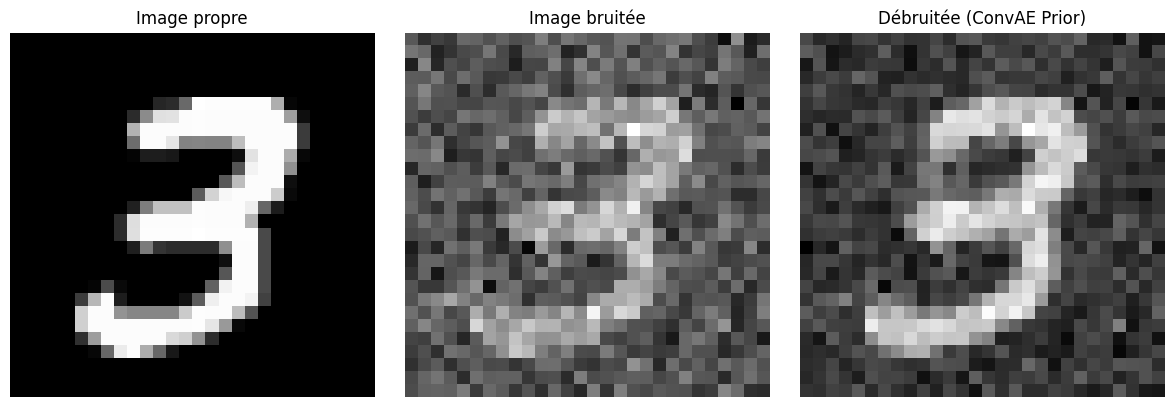

In [ ]:
# Autoencodeur convolutionnel
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # 28→14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # 14→7
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32 * 7 * 7, 64),  # latent dim = 64
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 32 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (32, 7, 7)),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

# Données MNIST
transform = transforms.ToTensor()
train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True)

# Entraînement de l'autoencodeur
ae = ConvAutoencoder()
optimizer = optim.Adam(ae.parameters(), lr=1e-3)
criterion = nn.MSELoss()

ae.train()
for images, _ in tqdm(train_loader, desc="Training ConvAE (1 epoch)"):
    optimizer.zero_grad()
    recon = ae(images)
    loss = criterion(recon, images)
    loss.backward()
    optimizer.step()

ae.eval()

# Ensembles
x_clean, _ = train_set[7]
x_clean = x_clean.unsqueeze(0)
sigma_noise = 0.3
x_noisy = x_clean + sigma_noise * torch.randn_like(x_clean)

# Paramètres MCGDiff
num_steps = 75
betas = torch.linspace(1e-4, 0.015, num_steps)
alphas = 1 - betas
cum_alphas = torch.cumprod(alphas, dim=0)

n_particles = 300
x_particles = torch.randn(n_particles, 1, 28, 28)
y = x_noisy.expand(n_particles, -1, -1, -1)
velocity = torch.zeros_like(x_particles)

# 6. Fonctions auxiliaires
def log_likelihood(x, y, sigma):
    return -((x - y)**2).view(len(x), -1).sum(dim=1) / (2 * sigma**2)

def resample(particles, weights):
    probs = torch.softmax(weights, dim=0)
    indices = torch.multinomial(probs, len(particles), replacement=True)
    return particles[indices]

# Boucle MCGDiff avec prior AE
x = x_particles.clone()
with torch.no_grad():
    for i in tqdm(reversed(range(1, num_steps))):
        alpha_t = cum_alphas[i]
        beta_t = betas[i]

        # Gradient log-posterior : likelihood + prior appris
        grad_likelihood = 3 * (y - x) / sigma_noise**2
        x_autoencoded = ae(x)
        grad_prior = -5 * (x - x_autoencoded) / 0.3**2  # poids du prior augmenté
        grad_log_post = grad_likelihood + grad_prior

        # Langevin + momentum
        x_mean = (1 / torch.sqrt(alphas[i])) * (x + beta_t * grad_log_post)
        velocity = 0.9 * velocity + 0.1 * (x_mean - x)
        x = x_mean + torch.sqrt(beta_t) * torch.randn_like(x) + velocity

        # Rééchantillonnage adaptatif (ESS)
        ll = log_likelihood(x, y, sigma_noise)
        probs = torch.softmax(ll, dim=0)
        ess = 1 / (probs**2).sum()
        if ess < 0.5 * n_particles:
            x = resample(x, ll)

# Reconstruction finale
x_est = x.mean(dim=0)

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(x_clean.squeeze(), cmap='gray')
axs[0].set_title("Image propre")
axs[1].imshow(x_noisy.squeeze(), cmap='gray')
axs[1].set_title("Image bruitée")
axs[2].imshow(x_est.squeeze().detach(), cmap='gray')
axs[2].set_title("Débruitée (ConvAE Prior)")
for ax in axs:
    ax.axis('off')
plt.tight_layout()
plt.show()

<font color=darkblue> Cette version montre qu’il est possible d’atteindre une qualité de reconstruction élevée avec un modèle relativement simple. L’autoencodeur apprend efficacement les structures attendues des chiffres et agit comme un prior informatif, tout en s’intégrant naturellement dans la logique de MCGdiff. Cela en fait une approche à la fois pragmatique et fidèle aux idées de l’article, adaptée à des projets rapides mais ambitieux. </font>

####  <font color=darkred> Bilan sur les versions testées </font>

Par rapport à la version 1, où le prior était la moyenne empirique des images MNIST, l’utilisation de l’autoencodeur convolutionnel dans la version 2 améliore clairement la qualité de la reconstruction :

En effet, les formes sont plus précises : les contours du chiffre sont plus nets et mieux définis. L’autoencodeur apporte une vraie information structurelle sur ce à quoi “ressemble” une image valide.

Le bruit résiduel est réduit : le bruit parasite est bien atténué, sans pour autant lisser ou déformer le chiffre comme dans certaines approches trop brutales.
- Adaptabilité : le prior appris s’ajuste mieux à des cas variés qu’une moyenne fixe, ce qui le rend plus robuste.

Finalement, les résultats “ressemblent” beaucoup plus à une vraie image MNIST propre, même en présence de fort bruit.

En revanche, le score basé sur un autoencodeur n’est pas aussi “justifié théoriquement” qu’un modèle de score entraîné par score matching, comme dans l’article. Mais il reste une approximation tout à fait raisonnable dans un cadre simplifié. De plus, il existe un coût d’entraînement initial (même si faible), contrairement à la version analytique.

En résumé, la version 2 (avec prior appris) permet d’améliorer significativement les résultats, tout en gardant une structure algorithmique fidèle au papier. C’est une bonne démonstration de l’intérêt d’intégrer de l’apprentissage léger dans une méthode probabiliste de type $\texttt{MCGdiff}$.